# Tutorial

This is a short tutorial describing basic functionalities of our software
implementing Multiscale Semiwalk Balance (MSB) formalism for measuring 
structural balance in (un)weighted, (un)directed signed networks.

For the sake of simplicity we will use the small dataset of Sampson's Monks
consisting of a network of relations of liking and disliking in a group
of monks from an American monastery in mid 20th century. There are five
points in time at which the relations were measured and between $t=4$
and $t=5$ the congregation has split due to rising conflicts and a subgroup
of monks has been expelled and subsequently followed by a voluntary departure
of several other apprentices.

This dataset is quite famous in social sciences and is considered
one of the standard dataset for structural balance analyses.
In general, we should expect rising levels of structural balance
towards the split, as high balance indicate how easy it is to split
the network into hostile coalitions.

We will also use our naive yet effective SBT-aware clustering method
to estimate how the frustration of the system evolved in time.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from msb import Balance

#%matplotlib inline
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.5,
    palette="deep"
)

# Paths
ROOT = Path(".").absolute().parent
DATA = ROOT/"data"/"sampson"

# Get network datasets
NETWORKS = tuple(
    ig.Graph.Read_GraphMLz(str(DATA/f"t{i}.graphml.gz"))
    for i in range(1, 6)
)
# Networks for specific timesteps
G1, G2, G3, G4, G5 = NETWORKS

/home/sztal/.conda/envs/msb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sztal/.conda/envs/msb/lib/python3.10/site-packages/igraph/io/files.py:189: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  return cls.Read_GraphML(tmpfile, index=index)


## Technical details

Networks are small, so we will use exact calculations based on full spectrum
(note `m=None` argument during initialization of `Balance` objects).

In general, the main type of object we will work with will be instances
of the `Balance` class (imported above). This is our main class which is 
initialized from a `igraph.Graph` instance (or sparse/dense matrix/2D array). 
It is equipped with all methods required for calculating
structural balance measures, including global balance, balance and contribution
profiles as well as node-wise pair-wise balance. It also comes with an 
easy-to-use method for finding near SBT-optimal partitions of networks.

**NOTE.** All methods and classes are relatively well-documented so in case
of any doubts you may find some helpful answers and other info in docstrings.

### Preliminary analysis for $t=1$

We start by doing a simple analysis for the network at $t=1$ to see how we
can use our software in practice. We will do the following things:

1. Calculate **global balance measures** (weak and strong) for different values
of the inverse temperature parameter $\beta$. Remember that $\beta$ controlls
the rate at which longer cycles are discounted so when $\beta < 1$ the more
emphasis is placed on short cycles. By studying the entire $\beta$ curve
we can get a very detailed, multiscale overview of the structure of a network
in terms of structural balance.
2. Calculate **contribution and balance profiles**. This analysis allows
us to see exactly how balanced a network is at particular cycle lengths
and how much any individual length contributes to the overall degree
of balance. This is another quite useful way in which we can probe
the structure of a network.
3. Calculate local degrees of balance (weak and strong) for individual nodes
as well as contributions of individual nodes to the overall degree of balance.
This will allow us to identify actors who are most important for introducing
or disrupting structural balance of the network.

In [2]:
### INITIALIZE 'Balance' INSTANCE
### `m=None` means that we will use exact calculations
### based on full spectrum.
B1 = Balance(G1, m=None)

### SEE DOCSTRING FOR `Balance` CLASS
?B1

Type:           Balance
String form:    <Balance with m=13 and K=2:13 on directed, weighted network with 13 nodes and 76 edges at 0x7f1186187ac0>
File:           ~/Projects/msb/msb/balance.py
Docstring:     
Structural balance computations.

Attributes
----------
A
    Adjacency matrix (sparse) of a graph.
    Possibly weighted. Can be passed as :py:class:`igraph.Graph`.
directed
    Boolean indicating if graph is directed.
    Determined automatically if ``None``.
kmin
    Minimum cycle length (adjacency matrix power) to consider
    in truncated walk balance calculations.
    If ``None`` then it is set to ``2`` for directed
    and to ``3`` for undirected networks.
kmax
    Minimum cycle length to consider.
    The actual value is set to ``min(kmax, self.n_nodes)``,
    since no elementary cycle can be longer than
    the number of nodes.
m
    Number of eigenvalues to use for approximating matrix powers.
beta
    Default values of inverse temperature parameter (``beta > 0``)
    use

### Global degree of balance

#### Strong balance

Remember that strong balance measure can be interpreted in terms of
how close a network is to be perfectly partitionable into two mutually
hostile coalitions (in-group links are only positive and out-group links
only negative).

We can calculate strong balance measures very easily using `balance` method.
Crucially, we can calculate this for multiple values of `beta` in one go,
in a fully vectorized (and therefore efficient) manner.

In [3]:
### STRONG BALANCE AT T=1

### We use `beta` values at 50 equally spaced points
### between `1` and `20`
beta = np.linspace(0.01, 3, num=50)
strong = B1.balance(beta=beta)
strong

beta
0.010000    0.726755
0.071020    0.709812
0.132041    0.694662
0.193061    0.680925
0.254082    0.668263
0.315102    0.656398
0.376122    0.645122
0.437143    0.634298
0.498163    0.623849
0.559184    0.613750
0.620204    0.604009
0.681224    0.594658
0.742245    0.585743
0.803265    0.577311
0.864286    0.569404
0.925306    0.562057
0.986327    0.555291
1.047347    0.549116
1.108367    0.543528
1.169388    0.538509
1.230408    0.534035
1.291429    0.530071
1.352449    0.526579
1.413469    0.523516
1.474490    0.520839
1.535510    0.518507
1.596531    0.516479
1.657551    0.514718
1.718571    0.513189
1.779592    0.511862
1.840612    0.510708
1.901633    0.509706
1.962653    0.508832
2.023673    0.508070
2.084694    0.507403
2.145714    0.506818
2.206735    0.506304
2.267755    0.505851
2.328776    0.505451
2.389796    0.505096
2.450816    0.504781
2.511837    0.504500
2.572857    0.504248
2.633878    0.504023
2.694898    0.503820
2.755918    0.503637
2.816939    0.503471
2.877959

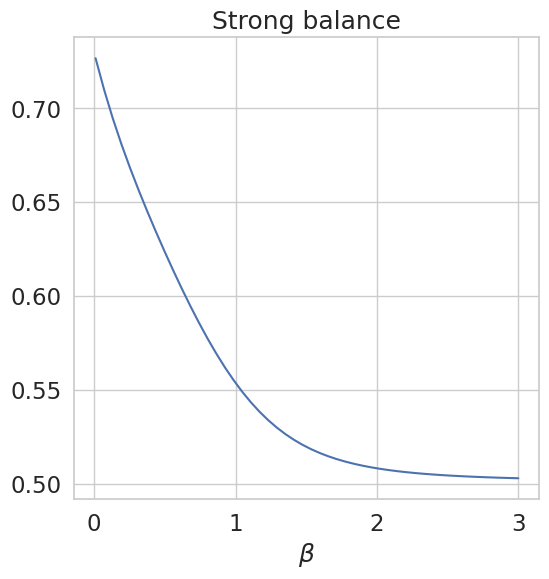

In [4]:
### We can now plot our results quite easily
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(strong.index, strong)
ax.set_xlabel(r"$\beta$")
ax.set_title(r"Strong balance")
None

We see that at time $t=1$ the level of balance is not very high,
even at the shortest scale. This makes sense as $t=1$ corresponds
to time before the inflow of several new monks after which the
tensions within the monastery started to build up. In other words,
the group was not so fragmented that it would be easy to split it up
into two hostile coalitions.

### Weak balance

However, weak balance levels are somewhat higher, which again makes sense,
since splitting into $k \geq 2$ groups is usually much easier than splitting
in exactly $2$ groups. In general, weak balance is never lower than strong 
balance as it corresponds to an easier criterion 
(splitting into multiple groups instead of only two).

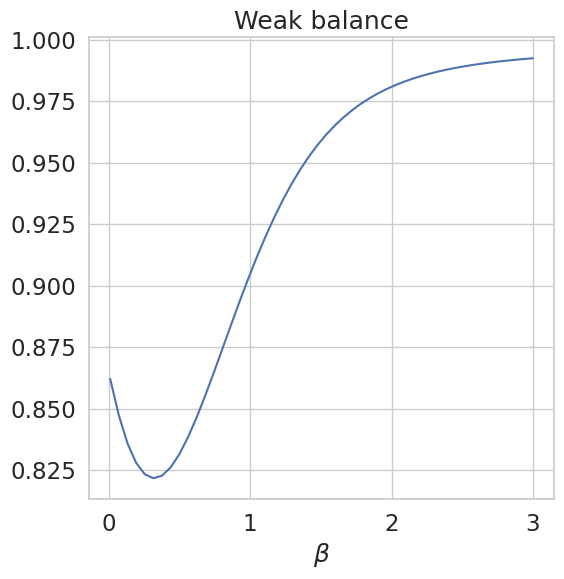

In [5]:
### WEAK BAlANCE
weak = B1.balance(weak=True, beta=beta) 

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(weak.index, weak)
ax.set_xlabel(r"$\beta$")
ax.set_title(r"Weak balance")
None

Note that in this case the balance grows as we consider longer cycles
(i.e. it grows to the right). This makes sense, a cycle is weakly unbalanced
only if it contains exactly one negative link. So in longer cycles in general
it becomes harder and harder for this to occur.

Nonetheless, even weak balance measures are relatively low at shorter length
scales in this case indicating that indeed the group was not very fragmented 
at this time.

## Contribution and balance profiles

We can get a more detailed insight into structure of the network
at different length scales by studying its contribution and balance profiles.

Let us start with the balance profile. It shows what is the degree of balance
at particular length scales, that is, for cycles of specific lengths.
We will now compute both strong and weak balance profiles.

**NOTE.** Balance profile does not depend on `beta`.

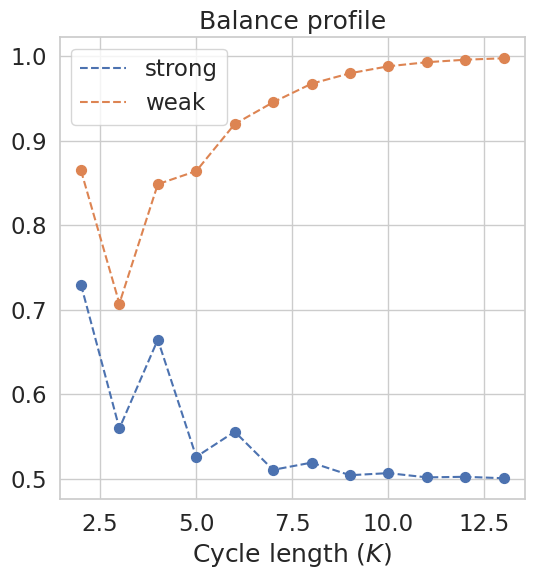

In [6]:
## STRONG BALANCE PROFILE
strong = B1.local_balance()
weak = B1.local_balance(weak=True)
### We use convenience method `K` to get the default 
### sequence of powers used in truncated exponential calculations
K = B1.K()

### `profile` method returns a tuple with two elements
### 1. contribution profile
### 2. balance profile
###
### Following Python convention we assigned the controbution profile to `_`
### variable as we want to ignore it for now.
### We will recalculate it later for multiple values of `beta`.

fig, ax = plt.subplots(figsize=(6,6))

for P in (strong, weak):
    ax.plot(P.index, P, ls="--", label=P.name.split()[0])
    ax.scatter(P.index, P, s=50)
ax.set_xlabel(r"Cycle length ($K$)")
ax.set_title(r"Balance profile")
ax.legend()
None

The results agrees with the previous analysis. Strong balance decreases
at longer scales while weak balance increases. Again, this is due to the
simple fact that bi-partitioning is easier is small groups while 
arbitrary multi-partitioning becomes rather trivial in large systems.

We can now calculate the contribution profile for multiple values
of `beta` to see how much different lengths contribute to the overall
structural balance. Note that from the perspective of contribution
profile there is no difference between strong and weak balance,
since contributions are based only on unsigned closed walks.

In [7]:
contrib = B1.contrib(beta=beta)
contrib

beta  K 
0.01  2     9.822953e-01
      3     1.735412e-02
      4     3.466365e-04
      5     3.862034e-06
      6     4.156131e-08
                ...     
3.00  9     5.371509e-02
      10    9.992909e-02
      11    1.686589e-01
      12    2.611727e-01
      13    3.731746e-01
Name: contrib, Length: 600, dtype: float64

/tmp/ipykernel_775864/901879442.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=mpl.cm.get_cmap("coolwarm_r")


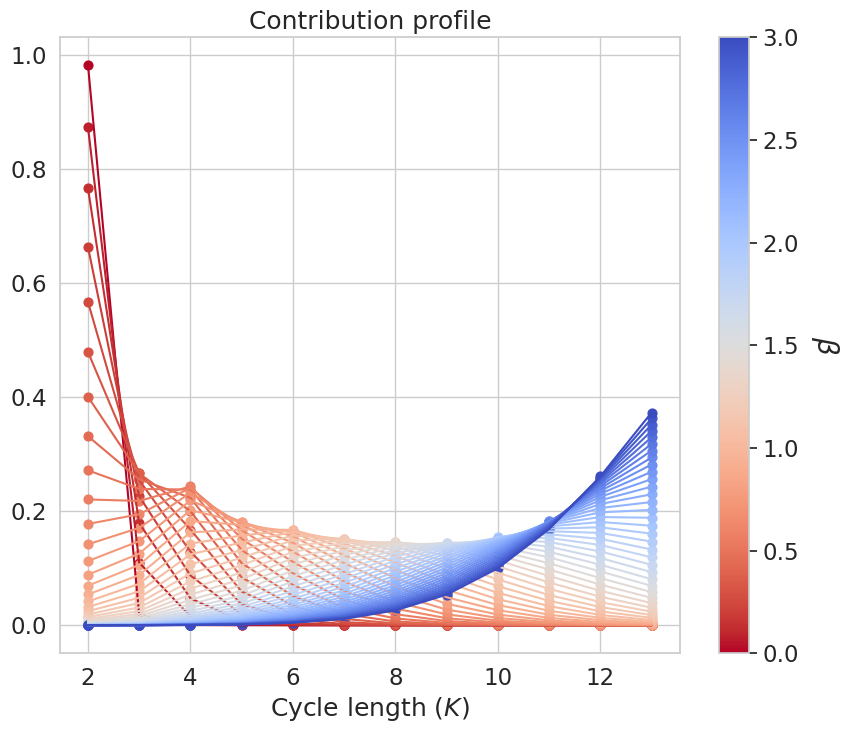

In [8]:
K = B1.K()

cm = mpl.cm.ScalarMappable(
    norm=mpl.colors.Normalize(vmin=0, vmax=beta.max()),
    cmap=mpl.cm.get_cmap("coolwarm_r")
)

fig, ax = plt.subplots(figsize=(10, 8))

for t, C in contrib.groupby(level="beta"):
    C = C.droplevel("beta")
    color = cm.to_rgba(t)
    ax.plot(C.index, C, color=color)
    ax.scatter(C.index, C, color=color, s=40)

ax.set_xlabel("Cycle length ($K$)")
ax.set_title("Contribution profile")
cb = fig.colorbar(cm, ax=ax)
cb.ax.set_ylabel(r"$\beta$", fontsize=20, rotation=270, labelpad=30)
None

As the above plot shows, contribution for longer cycles ($5+$) are greater
than zero only for high values of $\beta$. On the other hand, for low values,
$\beta \ll 1$, the contribution profile is dominated by short cycles.

## Evolution of the system

We will now try to study the evolution of the system using the main methods
of SWB approach. Thus, for all time steps we will estimate strong and weak
DoB of the system, find near-optimal partitions into coalitions and calculate
their frustration index values, which are objective measures of the extent
to which a given partition of a system is balanced 
(in-group ties are only positive and out-group ties are negative).

In all cases the 'optimal' inverse temperature $\beta = \beta_{\max}$
derived from the Locality Principle will be used.

**NOTE.**

``Balance`` instances automatically find $\beta_{\max}$ when initialized
without setting ``beta`` attribute to any value.

In [9]:
times       = np.array([ G["t"] for G in NETWORKS ], dtype=int)
dob_strong  = np.empty(len(NETWORKS), dtype=float)
dob_weak    = np.empty(len(NETWORKS), dtype=float)
frustration = np.empty(len(NETWORKS), dtype=float)

for i, G in enumerate(NETWORKS):
    B = Balance(G)
    dob_strong[i] = B.balance()
    dob_weak[i] = B.balance(weak=True)
    fidx, _ = B.find_clusters()
    frustration[i] = fidx

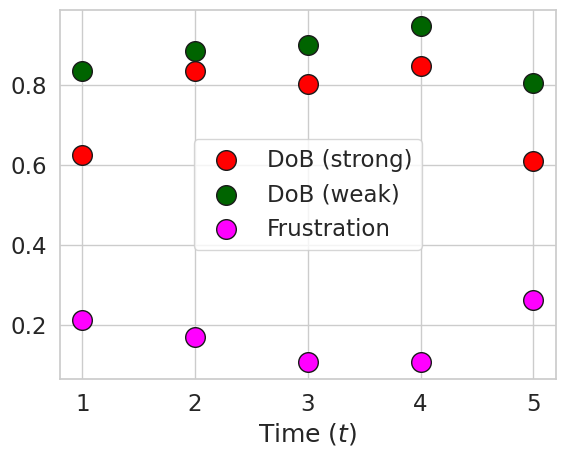

In [10]:
fig, ax = plt.subplots()

skws = dict(s=200, edgecolors="k")
ax.scatter(times, dob_strong, c="red", **skws, label="DoB (strong)")
ax.scatter(times, dob_weak, c="darkgreen", **skws, label="DoB (weak)")
ax.scatter(times, frustration, c="magenta", **skws, label="Frustration")

ax.set_xlabel("Time ($t$)")
ax.legend()

Clearly, DoB measures are maximized and frustration is minimized at $t=4$,
which is exactly the moment just before the culmination of the conflict
and the disintegration of the group. Thus, our results are perfectly
consistent with the predictions of structural balance theory.